# Exploratory data analysis

In [1]:
#the used packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
import warnings 
from warnings import filterwarnings
filterwarnings("ignore")


The data is downloaded for [Kaggel](https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance).

The data can be uesed as an example for predictive maintenance model building.
It consists of 5 csv file:
1. Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.
2. Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.
3. Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.
4. Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.
5. Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

# About Dataset

In [2]:
#loading the data
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_errors=pd.read_csv('data/PdM_errors.csv')
df_maint=pd.read_csv('data/PdM_maint.csv')
df_failures=pd.read_csv('data/PdM_failures.csv')
df_machines=pd.read_csv('data/PdM_Machines.csv')

# Helper Function

In [3]:
def change_into_Datetime(df,col):
    '''
    This function takes a data frame and a column and change the type of column to timestamp. 
    '''
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")
    return (df[col].dtypes)

In [4]:
def set_sort_datetime_index(df):
    '''
    This function take a data frame, sort it by datetime column, set the datetime column as index.
    '''
    df.set_index('datetime', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    return df.head(5)

In [5]:
def check_duplicate(df,subset):
    doplicate_index=df.duplicated(subset=subset)
    if True in doplicate_index :
        return 'There is no douplication', doplicate_index
    else:
        return 'There is no douplication'

In [6]:
def check_missing_dates(datetime_series, start_date, end_date, freq):
    """
    This function take a date time series and check if there is missing data using the defined frequency between the start_date and end_date 
    retrun the missing data.
    """
    missing_date=pd.date_range(start=start_date, end=end_date, freq=freq).difference(datetime_series)
    if len(missing_date)!= 0:
        return missing_date
    else:
        return 'No missing data.'


# Data understand

## Telemetry data 

In [7]:
df_telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [8]:
df_telemetry['datetime'].min(), df_telemetry['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 06:00:00')

In [9]:
check_missing_dates(df_telemetry.datetime, start_date="2015-01-01 06:00:00", end_date="2016-01-01 06:00:00", freq='H')

'No missing data.'

In [10]:
df_telemetry[['volt', 'rotate', 'pressure', 'vibration']].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


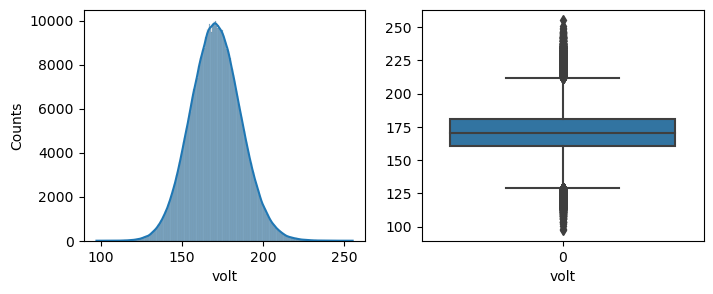

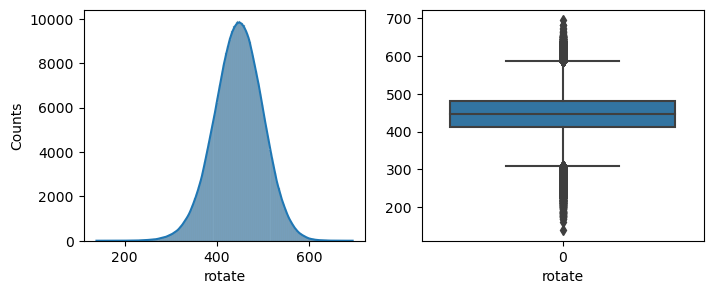

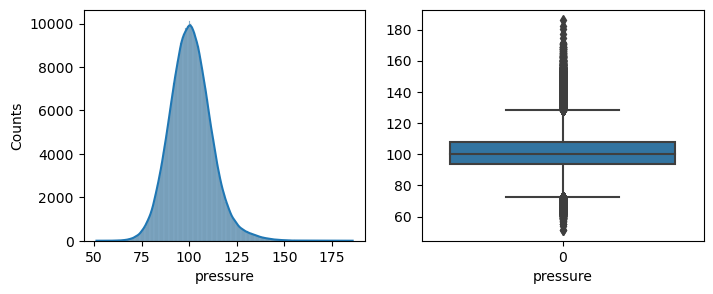

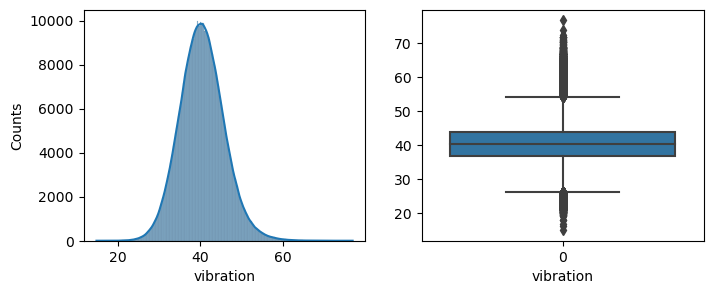

In [11]:
for column in ['volt', 'rotate', 'pressure', 'vibration']:
    plt.figure(figsize = (8,3))
    ax = plt.subplot(1,2,1)     
    sns.histplot(data=df_telemetry[column], kde=True )
    plt.xlabel(column)
    plt.ylabel('Counts')
    ax = plt.subplot(1,2,2)
    sns.boxplot(data=df_telemetry[column])
    plt.xlabel(column)
    plt.show()

The data seems to be normally distributed. Let's do the Shapiro-Wilk test. The null hypothesis is states that the population is normally distributed i.e if the p-value is greater than 0.05, then the null hypothesis is accepted.

In [12]:
from scipy.stats import shapiro
for column in ['volt', 'rotate', 'pressure', 'vibration']:
    result=shapiro(df_telemetry[column])
    if result[1] > 0.05 :
        print ('The {0} data is normally distributed. The p-vlaue is larger than 0.05 therefore the  null hypothesis is accepted'.format(column))
    else:
        print ('The {0} data is not normally distributed. The p-vlaue is less than 0.05 therefore the  null hypothesis is rejected'.format(column))


The volt data is not normally distributed. The p-vlaue is less than 0.05 therefore the  null hypothesis is rejected
The rotate data is not normally distributed. The p-vlaue is less than 0.05 therefore the  null hypothesis is rejected
The pressure data is not normally distributed. The p-vlaue is less than 0.05 therefore the  null hypothesis is rejected
The vibration data is not normally distributed. The p-vlaue is less than 0.05 therefore the  null hypothesis is rejected


<Axes: >

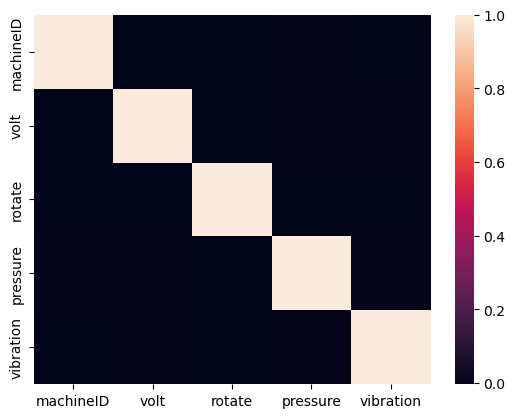

In [13]:
# plot the correlation between the variables
correlation=df_telemetry.corr(numeric_only=True)
sns.heatmap(correlation) 

There is no correlation.

In [14]:
check_duplicate(df_telemetry, ['datetime', 'machineID'])

'There is no douplication'

In [15]:
print("The 'datetime' column is ascending sorted :",df_telemetry["datetime"]. is_monotonic_increasing)
print("The 'datetime' column is descending sorted :",df_telemetry["datetime"]. is_monotonic_decreasing)

The 'datetime' column is ascending sorted : False
The 'datetime' column is descending sorted : False


## Error data

In [16]:
df_errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


In [17]:
df_errors['errorID'].unique() # how many unique error in the data?

array(['error1', 'error3', 'error5', 'error4', 'error2'], dtype=object)

In [18]:
df_errors['datetime'].min(), df_errors['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 05:00:00')

In [19]:
check_duplicate(df_errors, ['datetime'])

'There is no douplication'

In [20]:
print("The 'datetime' column is ascending sorted :",df_errors["datetime"]. is_monotonic_increasing)
print("The 'datetime' column is descending sorted :",df_errors["datetime"]. is_monotonic_decreasing)

The 'datetime' column is ascending sorted : False
The 'datetime' column is descending sorted : False


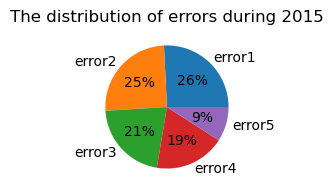

In [21]:
df_errors['errorID'].value_counts().plot(kind='pie',figsize=(6,2),autopct='%1.0f%%',ylabel='',title='The distribution of errors during 2015');

## Maintenance data

In [22]:
df_maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [23]:
df_maint.loc[df_maint['datetime']=='2015-01-02 03:00:00']

,datetime,machineID,comp


In [24]:
df_maint['datetime'].min(), df_maint['datetime'].max()

('2014-06-01 06:00:00', '2016-01-01 06:00:00')

In [25]:
check_duplicate(df_maint, ['datetime'])

'There is no douplication'

In [26]:
print("The 'datetime' column is ascending sorted :",df_maint["datetime"]. is_monotonic_increasing)
print("The 'datetime' column is descending sorted :",df_maint["datetime"]. is_monotonic_decreasing)

The 'datetime' column is ascending sorted : False
The 'datetime' column is descending sorted : False


In [27]:
df_maint['comp'].unique() # what componets are replaced during maintenance?

array(['comp2', 'comp4', 'comp3', 'comp1'], dtype=object)

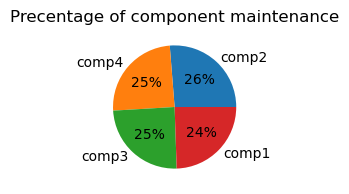

In [28]:
df_maint['comp'].value_counts().plot(kind='pie',figsize=(6,2),autopct='%1.0f%%',ylabel='',title='Precentage of component maintenance');

## Failures data

In [29]:
df_failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


In [30]:
df_failures['datetime'].min(), df_failures['datetime'].max()

('2015-01-02 03:00:00', '2015-12-31 06:00:00')

In [31]:
check_duplicate(df_failures, ['datetime'])

'There is no douplication'

In [32]:
print("The 'datetime' column is ascending sorted :",df_failures["datetime"]. is_monotonic_increasing)
print("The 'datetime' column is descending sorted :",df_failures["datetime"]. is_monotonic_decreasing)

The 'datetime' column is ascending sorted : False
The 'datetime' column is descending sorted : False


In [33]:
df_failures['failure'].unique()

array(['comp4', 'comp1', 'comp2', 'comp3'], dtype=object)

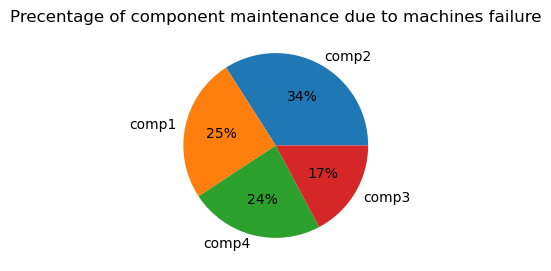

In [34]:
df_failures['failure'].value_counts().plot(kind='pie',figsize=(6,3),autopct='%1.0f%%',ylabel='',title='Precentage of component maintenance due to machines failure');

Let's check if all the data in the failures file is recorded in the maintenance file.

In [35]:
is_failures_in_maintenance = df_failures['datetime'].isin(df_maint['datetime']).all().all()

if is_failures_in_maintenance:
    print("All data in the failures file exists in the maintenance.")
else:
    print("Not data in the failures file exists in the maintenance.")

Not data in the failures file exists in the maintenance.


So not all failures data is in the other file. Which data is not exists?

In [36]:
failures_not_in_maintenance = df_failures['datetime'][~df_failures['datetime'].isin(df_maint['datetime'])]

print(failures_not_in_maintenance)

94     2015-01-02 03:00:00
95     2015-01-02 03:00:00
107    2015-01-02 03:00:00
161    2015-01-02 03:00:00
256    2015-01-02 03:00:00
331    2015-01-02 03:00:00
373    2015-01-02 03:00:00
409    2015-01-02 03:00:00
422    2015-01-02 03:00:00
430    2015-01-02 03:00:00
523    2015-01-02 03:00:00
568    2015-01-02 03:00:00
578    2015-01-02 03:00:00
595    2015-01-02 03:00:00
627    2015-01-02 03:00:00
631    2015-01-02 03:00:00
690    2015-01-02 03:00:00
739    2015-01-02 03:00:00
Name: datetime, dtype: object


## Machines data

In [37]:
df_machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [38]:
df_machines['model'].unique()

array(['model3', 'model4', 'model2', 'model1'], dtype=object)

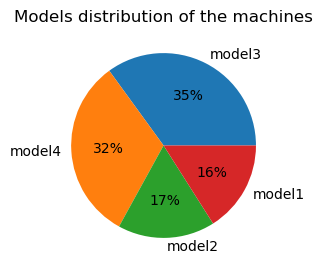

In [39]:
df_machines['model'].value_counts().plot(kind='pie',figsize=(6,3),autopct='%1.0f%%',ylabel='',title='Models distribution of the machines');

In [40]:
print('The minimum machine age is ',df_machines['age'].min(),'. The maximum machine age is ',df_machines['age'].max())

The minimum machine age is  0 . The maximum machine age is  20


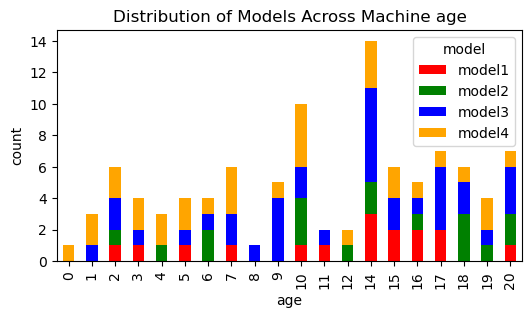

In [41]:
df_machines[['age','model']].groupby(['age']).value_counts().unstack().plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count', color={"model1": "red", "model2": "green","model4": "orange", "model3": "blue"},
                                                                           title='Distribution of Models Across Machine age');


## Observation:

- No null values in the data and no duplication.
- The data is recorded hourly between 2015-01-01 06:00:00'and '2016-01-01 06:00:00'. The maintenance data collected form '2014-06-01 06:00:00'.
- There is 100 machines with 4 model: model1 (16%), model2(17%), model3(32%), model4 (35%). 
- The age of machines range form 0 year (only one machine) to 20 years (7 machine) most frequented age is 14 years (14 machines).
- There is 5 errors types: error1, error2, error3, error4, error5.
- There is 3919 errors recorded during 2015.
- The maintenance of the machines containe a replacement of one of four component,('comp1','comp2','comp3','comp4').
- The most repeated errors is error1 and error 2. Also erro 3 is very freqent then come error 4. Error 5 is the less frequent.
- The frequency of changing the components 1-4 During maintaince is similar.
- The component 2 is the most ferquently changed due to a fauilre. Then comp 1, comp 4, comp 3, respectively.
- There is 3286 maintenance done between 2014-06-01 and  2016-06-01 where 761 are done because of machine failure.



# Data Analysis

Add a new colunm 'maintenance' to maintenance data with two values 'proactive' and 'reactive'. The value 'proactive' is givin when a component is replaced befour a failure happen , i.e. the data exsist only in the df_maint. The value 'reactive' is givin when a component is replaced after a failure happen , i.e. the data exsist in both the df_maintenance and df_failures. 

In [42]:
# merge the maintenance data and failures data
df_failures.rename(columns={'failure': 'comp'}, inplace=True)
#df_maint_fail = pd.merge(df_maint, df_failures, how='left', left_on=['datetime','machineID','comp'],right_on=['datetime','machineID','failure'],indicator='exists')
#df_maint_fail['maintenance'] = np.where(df_maint_fail.exists == 'both' , "reactive",'proactive')
df_maint_fail = pd.merge(df_maint, df_failures, how='outer',indicator='exists')
df_maint_fail['maintenance'] = df_maint_fail.apply(lambda row: 'proactive' if row['exists'] == 'left_only' else 'reactive' , axis=1)
df_maint_fail = df_maint_fail.drop(['exists'], axis=1)
df_maint_fail

,datetime,machineID,comp,maintenance
0,2014-06-01 06:00:00,1,comp2,proactive
1,2014-07-16 06:00:00,1,comp4,proactive
2,2014-07-31 06:00:00,1,comp3,proactive
3,2014-12-13 06:00:00,1,comp1,proactive
4,2015-01-05 06:00:00,1,comp4,reactive
...,...,...,...,...
3299,2015-01-02 03:00:00,83,comp4,reactive
3300,2015-01-02 03:00:00,86,comp1,reactive
3301,2015-01-02 03:00:00,87,comp1,reactive
3302,2015-01-02 03:00:00,94,comp4,reactive


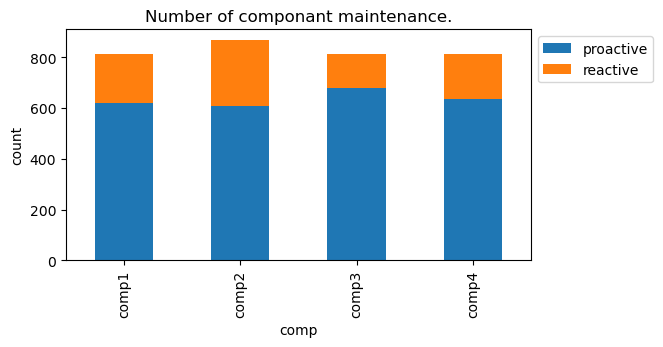

In [43]:
df_maint_fail[['maintenance','comp']].groupby(['comp']).value_counts().unstack().plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count',
                                                                                     title='Number of componant maintenance.').legend(bbox_to_anchor=(1.0, 1.0));

The componant 2 is failed more than other componant. 

In [44]:
# merge the previous data (maintenance and failures) with the machines data.
df_maint_fail_machine=pd.merge(df_maint_fail,df_machines,how='left',on=['machineID'])
df_maint_fail_machine

,datetime,machineID,comp,maintenance,model,age
0,2014-06-01 06:00:00,1,comp2,proactive,model3,18
1,2014-07-16 06:00:00,1,comp4,proactive,model3,18
2,2014-07-31 06:00:00,1,comp3,proactive,model3,18
3,2014-12-13 06:00:00,1,comp1,proactive,model3,18
4,2015-01-05 06:00:00,1,comp4,reactive,model3,18
...,...,...,...,...,...,...
3299,2015-01-02 03:00:00,83,comp4,reactive,model4,18
3300,2015-01-02 03:00:00,86,comp1,reactive,model3,2
3301,2015-01-02 03:00:00,87,comp1,reactive,model2,12
3302,2015-01-02 03:00:00,94,comp4,reactive,model2,18


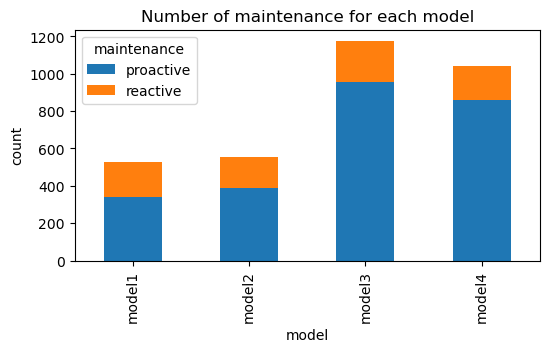

In [45]:
df_maint_fail_machine[['maintenance','model']].groupby(['model']).value_counts().unstack().plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count',
                                                                                               title='Number of maintenance for each model');

The last plot shows the number of maintence for each model. Because there is more machines with model 3 and model 4 than the other models we can not say that model 3 and 4 need more maintening. Let's plot number of maintening per machine.

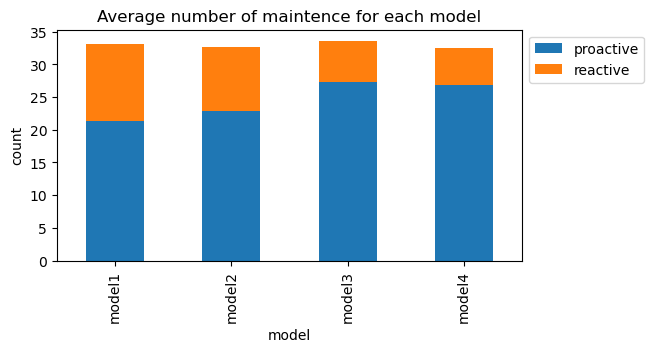

In [46]:
df1=df_maint_fail_machine[['maintenance','model']].groupby(['model']).value_counts().reset_index(name='nu_maint')
df2=df_machines['model'].value_counts().rename_axis('model').reset_index(name='counts')
df= pd.merge(df1,df2 , on=['model'])
df['ave_maint']=df['nu_maint']/df['counts'].astype(int)
pivot = pd.pivot_table(data=df, index=['model'], columns=['maintenance'], values='ave_maint')
pivot.plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count',title='Average number of maintence for each model').legend(bbox_to_anchor=(1.0, 1.0));

Now we can see that machines with model 3 and model 4 had a slightly more proactive maintenance but less reactive maintenance than the other models.

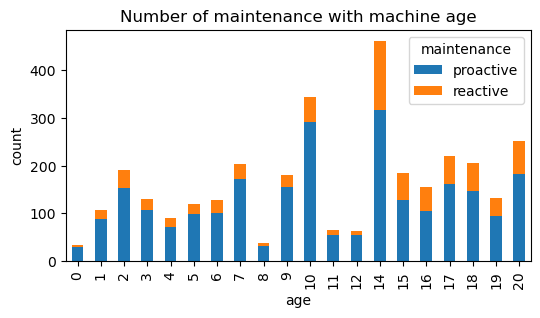

In [47]:
df_maint_fail_machine[['maintenance','age']].groupby(['age']).value_counts().unstack().plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count',
                                                                                           title='Number of maintenance with machine age');

For fair comparsion, let's plot the avrage number of maintaince with age.

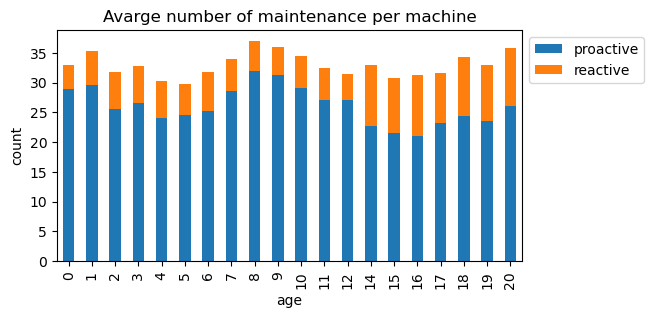

In [48]:
df1=df_maint_fail_machine[['maintenance','age']].groupby(['age']).value_counts().reset_index(name='nu_maint')
df2=df_machines['age'].value_counts().rename_axis('age').reset_index(name='counts')
df= pd.merge(df1,df2 , on=['age'])
df['ave_maint']=df['nu_maint']/df['counts'].astype(int)
pivot = pd.pivot_table(data=df, index=['age'], columns=['maintenance'], values='ave_maint')
pivot.plot(kind='bar', stacked=True,figsize=(6,3),ylabel='count',
          title='Avarge number of maintenance per machine').legend(bbox_to_anchor=(1.0, 1.0));

The proactive maintenance is not affected by age. But the reactive is affected. The number of reactive maintenance for machines age 14 and above is more. The machine with age 14 and obove has more failure.

In [49]:
# is there a record in the errors data and in the maintenance data  for each day in 2015, how many day is missing, which days are missing?
change_into_Datetime(df_errors,'datetime')
change_into_Datetime(df_maint,'datetime')
date_range = pd.date_range(start='2015-01-01', end='2016-01-01', freq='D')
missing_dates_error = date_range[~date_range.isin(df_errors['datetime'].dt.date)]
print('There is {0} days missing in the errors data in the year 2015.'.format(len(missing_dates_error)))
if len(missing_dates_error)!=0:
    print('The missing dates are:',missing_dates_error)
missing_dates_maint = date_range[~date_range.isin(df_maint['datetime'].dt.date)]
print('There is {0} days missing in the maintenance data in the year 2015.'.format(len(missing_dates_maint)))
if len(missing_dates_maint)!=0:
    print('The missing dates are:',missing_dates_maint)

There is 0 days missing in the errors data in the year 2015.
There is 7 days missing in the maintenance data in the year 2015.
The missing dates are: DatetimeIndex(['2015-01-12', '2015-01-29', '2015-02-28', '2015-06-11',
               '2015-07-11', '2015-07-28', '2015-08-12'],
              dtype='datetime64[ns]', freq=None)


In [50]:
#compute number of error per day for each machine
errorID_day=df_errors.groupby([df_errors['datetime'].dt.date,'machineID','errorID']).size().reset_index(name='errorID_count')
print ('Maximum unmber of the same errorID per machine per day is', errorID_day['errorID_count'].max())
error_day=df_errors.groupby([df_errors['datetime'].dt.date,'machineID']).size().reset_index(name='error_count')
print ('Maximum unmber of the error per machine per day is', error_day['error_count'].max())

Maximum unmber of the same errorID per machine per day is 2
Maximum unmber of the error per machine per day is 4


In [51]:
#compute number of maintenace per day for each machine
maint_comp_day=df_maint.groupby([df_maint['datetime'].dt.date,'machineID']).size().reset_index(name='manint_count')
print ('Maximum unmber of maintenance per machine per day is', maint_comp_day['manint_count'].max())
print ('Minimum unmber of maintenance per machine per day is', maint_comp_day['manint_count'].min())

Maximum unmber of maintenance per machine per day is 3
Minimum unmber of maintenance per machine per day is 1


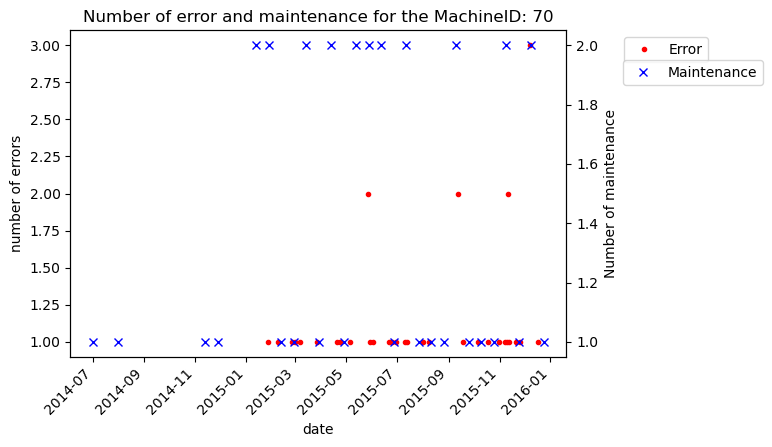

In [52]:
# plot the timeline for a machine

machineID=70 # choose the machine ID

change_into_Datetime(df_maint,'datetime')

nu_error_machine = df_errors[df_errors.machineID.isin([machineID])].datetime.dt.date.value_counts().sort_index()
nu_maint_machine = df_maint[df_maint.machineID.isin([machineID])].datetime.dt.date.value_counts().sort_index()
fig, ax1 = plt.subplots()

ax1.set_ylabel('number of errors')
ax1.plot(nu_error_machine ,'.', color = 'red',)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of maintenance')
ax2.plot(nu_maint_machine,'x', color = 'blue')

ax1.legend(['Error'],bbox_to_anchor=(1.3, 1.0))
ax2.legend(['Maintenance'],bbox_to_anchor=(1.41, 0.93))

ax1.set_xlabel('date')
fig.autofmt_xdate(rotation=45)

plt.title('Number of error and maintenance for the MachineID: {0}'.format(machineID))

plt.show()


The errors are followed by maintenace.

Let's check the correlation between age, number of errors, number of failure, number of proactive maintenance and total number of maintenance (active and proactive). 

In [53]:
proactive_maint=df_maint_fail_machine[df_maint_fail_machine['maintenance']=='proactive']
nu_proactive_maint=proactive_maint['age'].value_counts().reset_index(name='number of proactive maintenance')
reactive_maint=df_maint_fail_machine[df_maint_fail_machine['maintenance']=='reactive']
nu_failure=reactive_maint['age'].value_counts().reset_index(name='number of failure')
age_nu_maint=pd.merge(nu_proactive_maint, nu_failure,how='outer')
age_nu_maint['total number of maintenance']=age_nu_maint['number of proactive maintenance']+age_nu_maint['number of failure']

df_error_machine=pd.merge(df_errors,df_machines,how='left',on=['machineID'])
nu_error_machine=df_error_machine['age'].value_counts().reset_index(name='number of error')

age_nu_maint_error=pd.merge(age_nu_maint, nu_error_machine,how='outer')
age_nu_maint_error.rename(columns={'index': 'age'}, inplace=True)
#age_nu_maint_error=age_nu_maint_error.drop(columns='index')


correlation=age_nu_maint_error.corr(numeric_only=True)
correlation

,age,number of proactive maintenance,number of failure,total number of maintenance,number of error
age,1.000000,0.324169,0.545882,0.404657,0.383850
number of proactive maintenance,0.324169,1.000000,0.830917,0.985162,0.929021
number of failure,0.545882,0.830917,1.000000,0.914081,0.959417
total number of maintenance,0.404657,0.985162,0.914081,1.000000,0.973066
number of error,0.383850,0.929021,0.959417,0.973066,1.000000


The age of machines is a little correlated with number of failure but not much correlated with number of errors or with number of proactive maintenance.
The number of maintenance is higly correlated with number of errors.

## Observation summery

- The frequency of proactive maintenance is almost the same for the four components, while the frequency of reactive maintenance for Component 2 is higher than the others. In other words, the failure rate of Component 2 surpasses that of the remaining components.
- The average number of proactive maintenance for machines with Model 3 and Model 4 is higher compared to Model 1 and Model 2, whereas the frequency of reactive maintenance is lower.
- The number of failures for older machine (age 14 and more) is more. However, number of proactive maintenance is not related to age. 
- The errors data contains at least one record each day in 2015. Which mean there is at least one machine give an error every day.
- The maintenance data contains a record every day in 2015 except 7 days. We can say with a good approximation that there is one one maintenance done each day.
- A machine shows the same errors maximum 2 times a day. And shows maxium 4 errors a day.
- Some machines had 3 time maintening in a day. 
- Even though, the errors don't shut down the machines. We can notice that maintenance is done after a few errors. Errors prediction might be useful.
- The age of machines shows a weak correlation with the number of failures.  Correlation with the number of errors and proactive maintenance is insignificant. On the other hand, there is a strong correlation between the number of maintenance activities and the number of errors.